In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn import tree
import concurrent.futures as cf
import os
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
file = "ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(file)

'''77% of the data was generated synthetically using the Weka tool and the SMOTE filter, 23% of the data was 
collected directly from users through a web platform. According to Data Brief'''
# Round age, and Weight to integer; Round Height to 2 decimal places; As for other float64-type varialbes, they should be integer
integer = ["Age", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
df[integer] = df[integer].apply(np.int64)
df = df.round({"Height": 2})


# convert categorical variables
for column in df.columns:
    if df[column].dtypes == "object":
        df[column] = pd.factorize(df[column])[0]
        
# define x and y
x = df[df.columns[0:16]]; y = df[df.columns[16]]

# split the data into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 2)

times = list(np.linspace(100, 1414, num=10)) # create equal spaced sample size
times = [int(x) for x in times] # convert times to integer
print(times)

y_test = np.array(list(y_test))

[100, 246, 392, 538, 684, 830, 976, 1122, 1268, 1414]


In [14]:
# the decision tree classifier function
def f(n):
    X = x_train.sample(n=n,replace=True) # sample from training dataset
    Y = y_train.loc[list(X.index)] #get corresponding Y
    
    # fit the decision tree
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, Y) # fit the decision tree with the sample drawn
    
    # predict the obesity level with the decision tree
    y_predict = clf.predict(x_test)
    
    return (y_predict)

In [60]:
# decision tree (without bagging/bootstrap)
t1 = time.time()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)
t2 = time.time() - t1

print('The accuracy rate of decision tree is ', accuracy_score(y_test, y_predict),
   '\n The time taken for simple decision tree is ', t2)

The accuracy rate of decision tree is  0.945480631276901 
 The time taken for simple decision tree is  0.011224746704101562


In [24]:
# multi-processing function
def mult(n,m):
    #n is how large each sample is, m is how many samples are taken
    inputs = [n]*m

    if __name__ == "__main__":
        #uses current.futures module instead of multiprocessing
        with cf.ProcessPoolExecutor() as ex:
            #timing
            start = time.perf_counter()

            #uses map to map the function to the inputs and put into results list
            results = ex.map(f, inputs)
            
            #predicting the class
            pred = np.rint((np.mean([x for x in results], axis = 0)))

            #printing accuracy
            accu = accuracy_score(list(y_test),pred)

            finish = time.perf_counter()

            #time taken
            t = finish - start
            
            return [accu, t]


In [47]:
# create a dataframe the store the result
df_time = pd.DataFrame(columns = ['sample size'])
df_time['sample size'] = times
# df_time

# result
result = df_time['sample size'].apply(lambda x: mult(x, 1000))

# split the list to two columns
result = pd.DataFrame(result.to_list(), columns=['accuracy (parallel)', 'time taken (parallel)'])

# combine the result dataframe with df_time
df_time = df_time.join(result)

df_time



,sample size,accuracy (parallel),time taken (parallel)
0,100,0.664275,2.372030
1,246,0.833572,2.669824
2,392,0.866571,3.035222
3,538,0.886657,3.200023
4,684,0.889527,3.442165
5,830,0.901004,3.763556
6,976,0.906743,4.021943
7,1122,0.915352,4.279680
8,1268,0.915352,4.542170
9,1414,0.921090,5.050818


In [48]:
# for non-parallel computing
t2 = []; ac2 = []

for x in times: #n in parallel computing function
    start = time.perf_counter()
    q = []
    for y in range(1000): #m in parallel computing function   
        t=f(x)
        q.append(t)
    pred = np.rint((np.mean(q, axis = 0)))
    finish = time.perf_counter()
    
    t2.append(finish - start)
    ac2.append(accuracy_score(list(y_test),pred))

df_time['time taken (non-parallel)'] = t2
df_time['accuracy (non-parallel)'] = ac2


In [49]:
df_time

,sample size,accuracy (parallel),time taken (parallel),time taken (non-parallel),accuracy (non-parallel)
0,100,0.664275,2.372030,2.439101,0.672884
1,246,0.833572,2.669824,2.817283,0.829268
2,392,0.866571,3.035222,3.176890,0.865136
3,538,0.886657,3.200023,3.582444,0.882353
4,684,0.889527,3.442165,4.000368,0.889527
5,830,0.901004,3.763556,4.194197,0.898135
6,976,0.906743,4.021943,4.623439,0.905308
7,1122,0.915352,4.279680,4.808286,0.916786
8,1268,0.915352,4.542170,5.142107,0.916786
9,1414,0.921090,5.050818,5.476479,0.921090


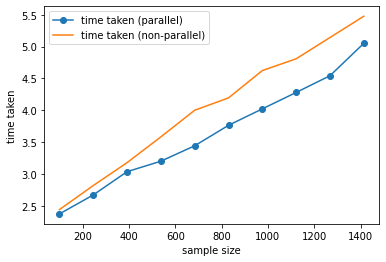

In [50]:
# visualization of time taken for the whole process
plt.plot('sample size', 'time taken (parallel)', data=df_time, marker = 'o')
plt.plot('sample size', 'time taken (non-parallel)', data=df_time, marker = '')

plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken')

plt.show()

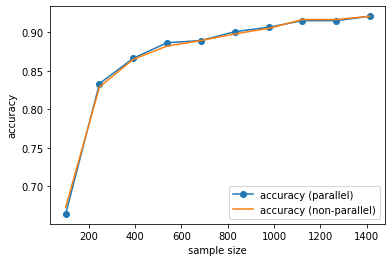

In [51]:
plt.plot('sample size', 'accuracy (parallel)', data=df_time, marker = 'o')
plt.plot('sample size', 'accuracy (non-parallel)', data=df_time, marker = '')

plt.legend()
plt.xlabel('sample size'); plt.ylabel('accuracy')

plt.show()

The accuracy rates of both parallel computing and non-parallel computing increase with bootstrap sample size, and reach the maximum when n=1414, i.e. the size of the training dataset. Even though the maximum accuracy rate is achieved when n = 1414, it is not significantly different from the accuracy rate of the decision tree without bootstrap. Parallel computing takes less time than non-parallel computing with the same bootstrap sample size.

In [66]:
# vary the number of bootstrap sample
num_boot = list(np.linspace(10, 1000, num=20))
num_boot = [int(i) for i in num_boot]

# dataframe to contain the result
df2 = pd.DataFrame(num_boot, columns=['number_bs'])

# result
result2 = df2['number_bs'].apply(lambda x: mult(1414, x))

# split the list to two columns
result2 = pd.DataFrame(result2.to_list(), columns=['accuracy (parallel)', 'time taken (parallel)'])

# combine the result dataframe with df_time
df2 = df2.join(result2)

# df2



In [67]:
t3 = []; ac3 = []

for x in num_boot: #n in parallel computing function
    start = time.perf_counter()
    q = []
    for y in range(x): #m in parallel computing function   
        t=f(1414)
        q.append(t)
    pred = np.rint((np.mean(q, axis = 0)))
    finish = time.perf_counter()
    
    t3.append(finish - start)
    ac3.append(accuracy_score(list(y_test),pred))

df2['time taken (non-parallel)'] = t3
df2['accuracy (non-parallel)'] = ac3

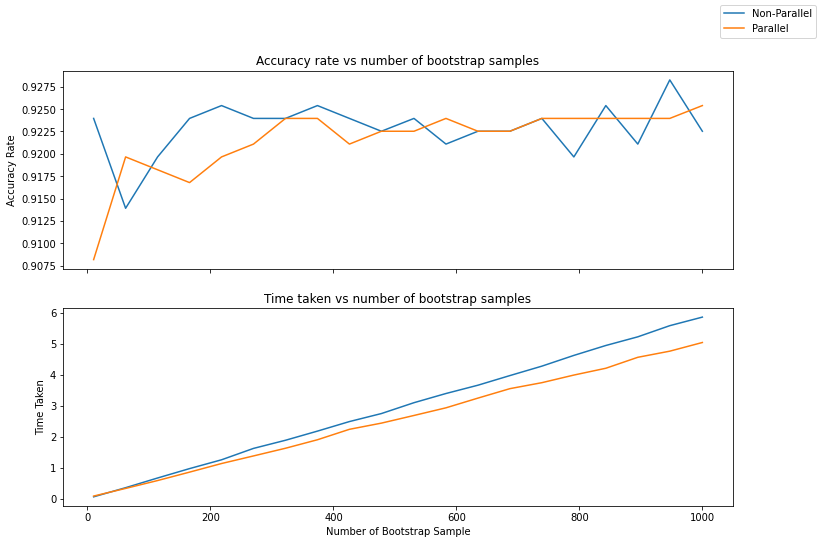

In [86]:
# visualize the result
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12, 8), sharex = True)
ax1.plot(df2['number_bs'], df2['accuracy (non-parallel)'])
ax1.plot(df2['number_bs'], df2['accuracy (parallel)'])
ax1.set_title('Accuracy rate vs number of bootstrap samples')
ax1.set_ylabel('Accuracy Rate')


ax2.plot(df2['number_bs'], df2['time taken (non-parallel)'])
ax2.plot(df2['number_bs'], df2['time taken (parallel)'])
ax2.set_title('Time taken vs number of bootstrap samples')
ax2.set_ylabel('Time Taken')
ax2.set_xlabel('Number of Bootstrap Sample')

fig.legend(labels = ('Non-Parallel', 'Parallel'))
fig.show()

There are some fluctuations of accuracy rate for different numbers of bootstrap samples, but the patterns are not obvious. As for time taken, the time taken of the process increases with the number of bootstrap samples, and it takes less time for the parallel computing to complete the bagging process than non-parallel computing.